In [1]:
                                                                                                                                                                                                                                                    # Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)
!pip install scikit-learn

# Add path for LArMachineLearningData
import sys
pandoraMVADir = os.environ['MY_TEST_AREA'] + '/LArMachineLearningData/'
sys.path.append(pandoraMVADir + 'scripts')
!pip install seaborn
from PandoraBDT import *

# Import relevant SKLearn stuff
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics

# Set global params
testTrainFraction = 0.5
nCores = -1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Set some analysis specific things
trainingFile = pandoraMVADir + '../run/LowEBackgroundClusterMergingOutputFixed.csv'

BDTName = "LowEClusterMerging"

featureNames = ['Vertex Cluster Angle', 
                'Minimum Edge Hit Separation',
                'Cluster 1 N Hits', 
                'Cluster 2 N Hits', 
                'N Hits in Contact',
                'N Hits in Proximity',
                'Centroid Separation',
                'Average hit to hit Distance',
                'Centroid Vector X',
                'Centroid Vector Z',
                'Cluster 1 ADC',
                'Cluster 2 ADC',
               ]




# Set background and signal label names
params = {
    'labelNames': ['Leave Clusters','Merge Clusters'],
    'signalDefs': [0, 1],
    'signalCols': ['r', 'b'],
    'nBins': 100,
    'PlotStep': 1.0,
    'OptimalBinCut': 50,
    'OptimalScoreCut': 0.5,
    'nTrees': 100,
    'TreeDepth': 3,
    'logY': False
}

# Create the base BDT to vary the params from and compare to
baseBDT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=params['TreeDepth']),algorithm='SAMME', 
                         random_state=42, n_estimators=params['nTrees'])

# Split the data into many subsets to grid search over (Set seed for reproducibility)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [5]:
# Load the data
data, nFeatures, nExamples = LoadData(trainingFile, ',')
featuresOrg, labelsOrg = SplitTrainingSet(data, nFeatures)
features, labels = Randomize(featuresOrg, labelsOrg, True)

# Split into train and test samples
xTrain, yTrain, xTest, yTest = Sample(features, labels, testTrainFraction)

# Split into signal and background based on the true labels
signalFeatures = features[labels==1]
backgroundFeatures = features[labels==0]

# Check the features array is the same size as the feature names array
print (len(featureNames))
print (np.shape(features))
print('Total: '+str(len(features))+', signal: '+
      str(len(signalFeatures))+' and background: '+
      str(len(backgroundFeatures)))

12
(80138, 12)
Total: 80138, signal: 47072 and background: 33066


In [6]:
# Construct the Pandas dataframe
# First crete a dictionary
allDict = {featureNames[i]: features[:, i] for i in range(nFeatures)}
allDict.update({'Labels': labels})

# Create the Pandas dataframe, create seperate df for signal/background
df = pd.DataFrame(data=allDict)
df

,Vertex Cluster Angle,Minimum Edge Hit Separation,Cluster 1 N Hits,Cluster 2 N Hits,N Hits in Contact,N Hits in Proximity,Centroid Separation,Average hit to hit Distance,Centroid Vector X,Centroid Vector Z,Cluster 1 ADC,Cluster 2 ADC,Labels
0,0.727822,3.402820e+38,1.0,2.0,0.0,0.0,12.64720,0.00000,4.038940,11.985000,86.4617,0.000,0
1,0.895345,2.995530e+00,3.0,4.0,0.0,2.0,3.17775,3.42833,-3.084300,0.764954,426.1220,1430.040,1
2,-0.999980,4.998970e+00,4.0,3.0,0.0,0.0,5.44475,5.96298,-2.217930,4.972530,376.2620,674.877,1
3,0.999183,4.362880e+00,5.0,3.0,0.0,0.0,3.73524,4.98961,2.801100,2.471010,268.2890,1035.810,1
4,0.995693,3.402820e+38,2.0,4.0,0.0,0.0,49.02140,0.00000,37.674100,31.365000,362.3110,716.686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80133,0.071439,1.698330e+00,3.0,2.0,1.0,0.0,2.49707,2.29313,-2.467600,0.382507,624.8980,135.841,1
80134,0.985563,5.430940e+01,2.0,5.0,0.0,0.0,55.45010,0.00000,-53.511200,-14.535000,579.8020,1170.770,1
80135,-0.969248,3.402820e+38,1.0,2.0,0.0,0.0,4.23309,0.00000,0.464569,4.207520,188.5580,0.000,0
80136,0.187515,1.469570e+00,2.0,3.0,1.0,0.0,1.99699,1.91263,-1.634380,1.147510,164.9900,407.815,1


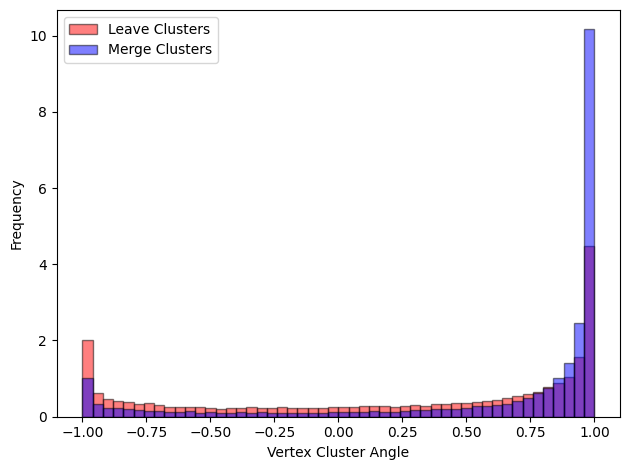

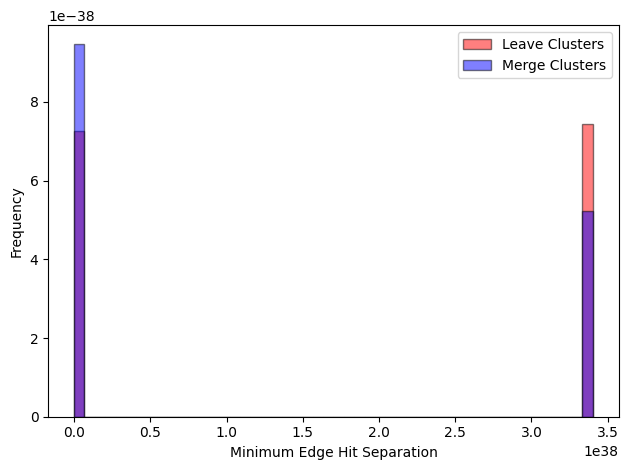

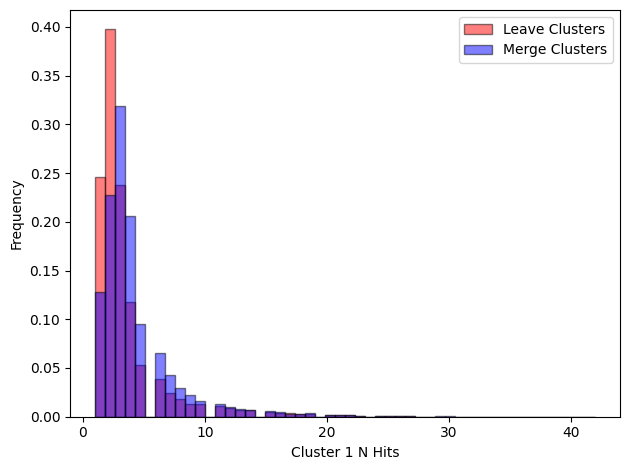

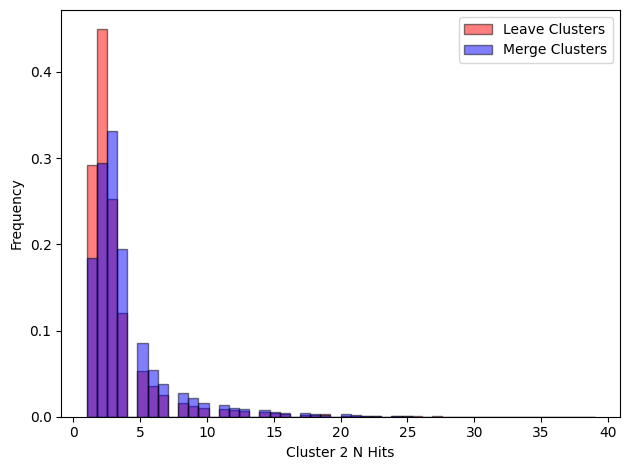

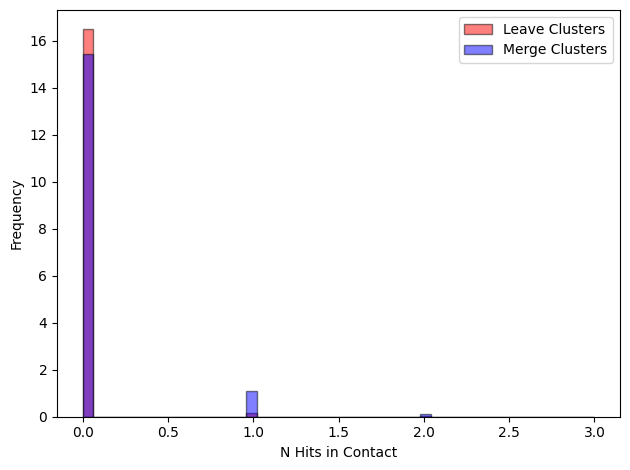

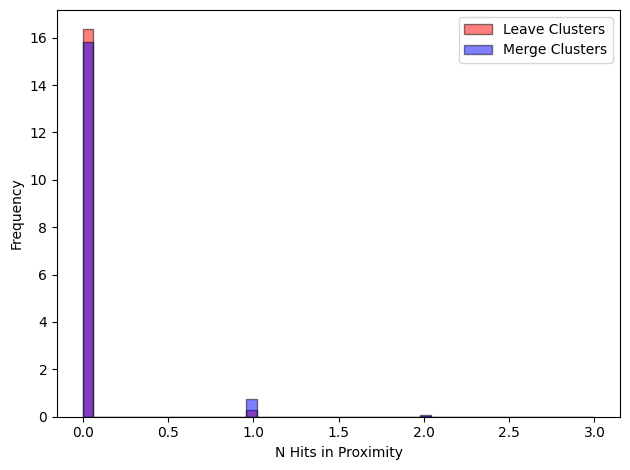

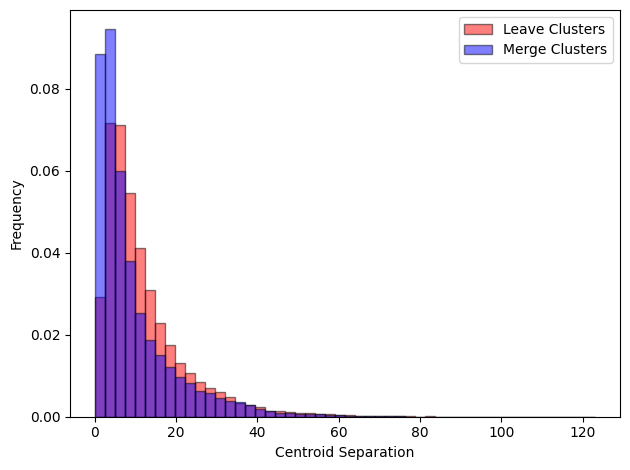

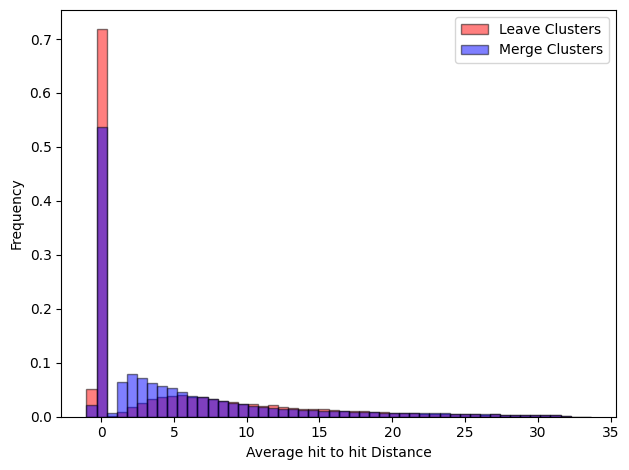

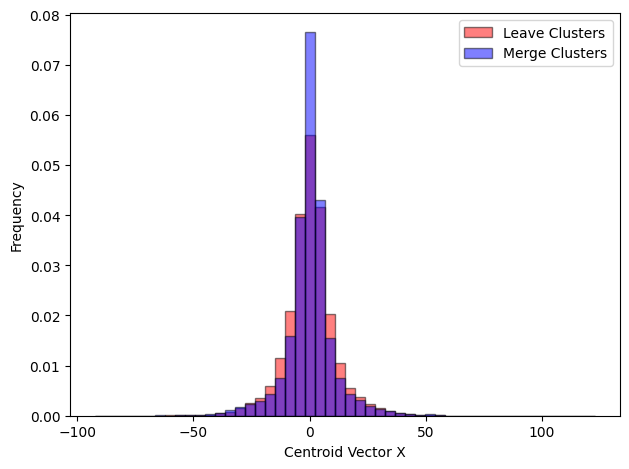

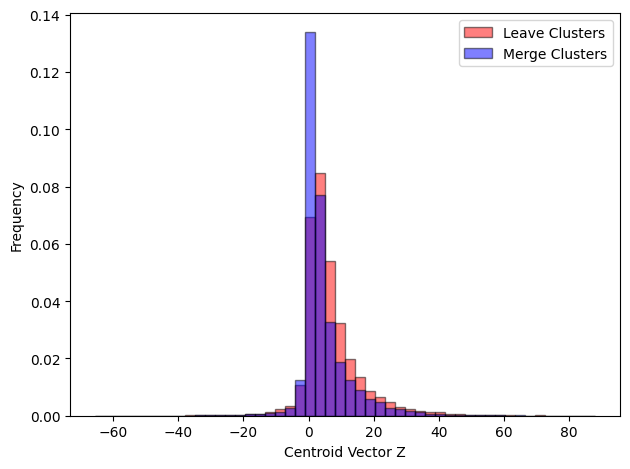

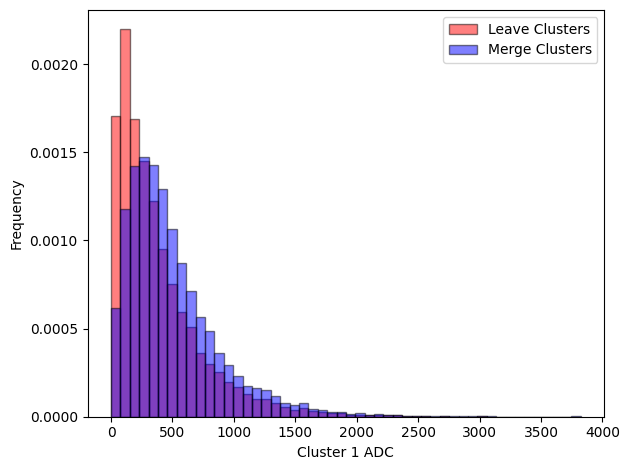

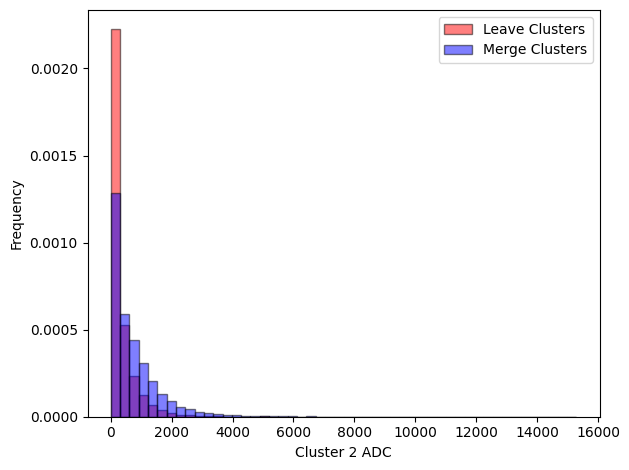

In [7]:
# Make plots drawing the variables for signal/background
DrawVariablesDF(df, params)

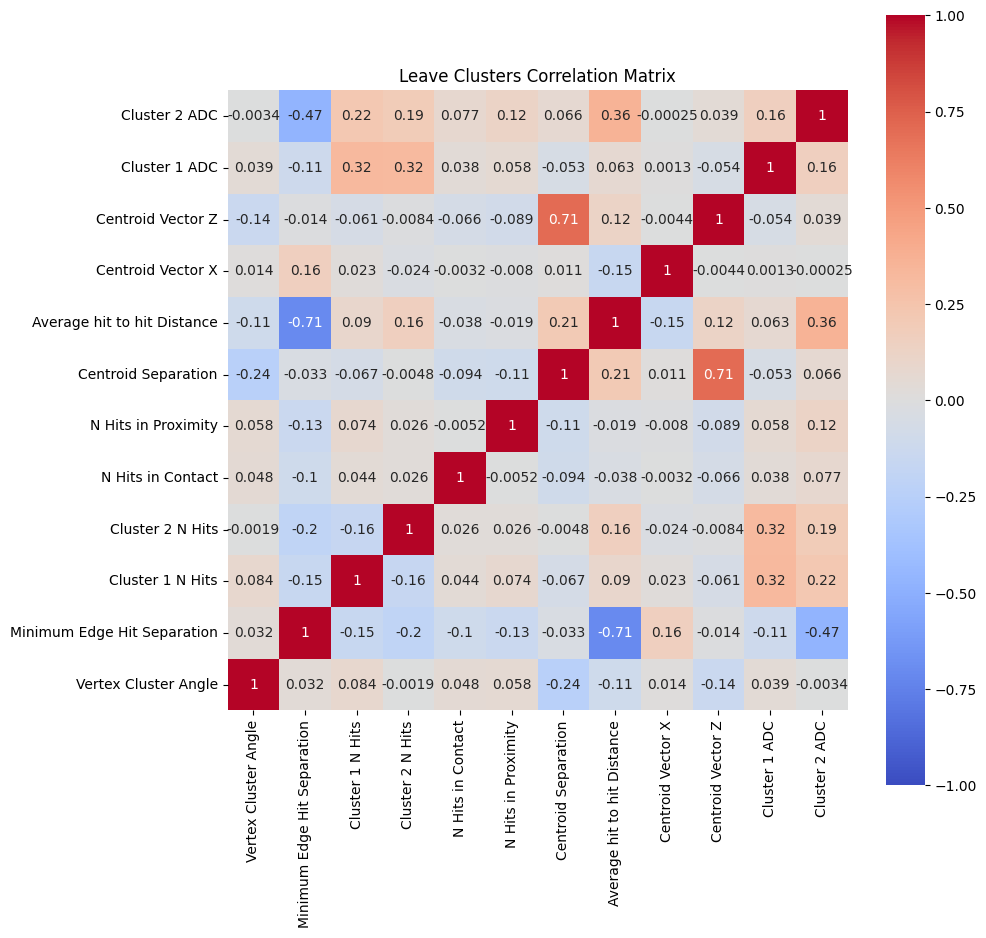

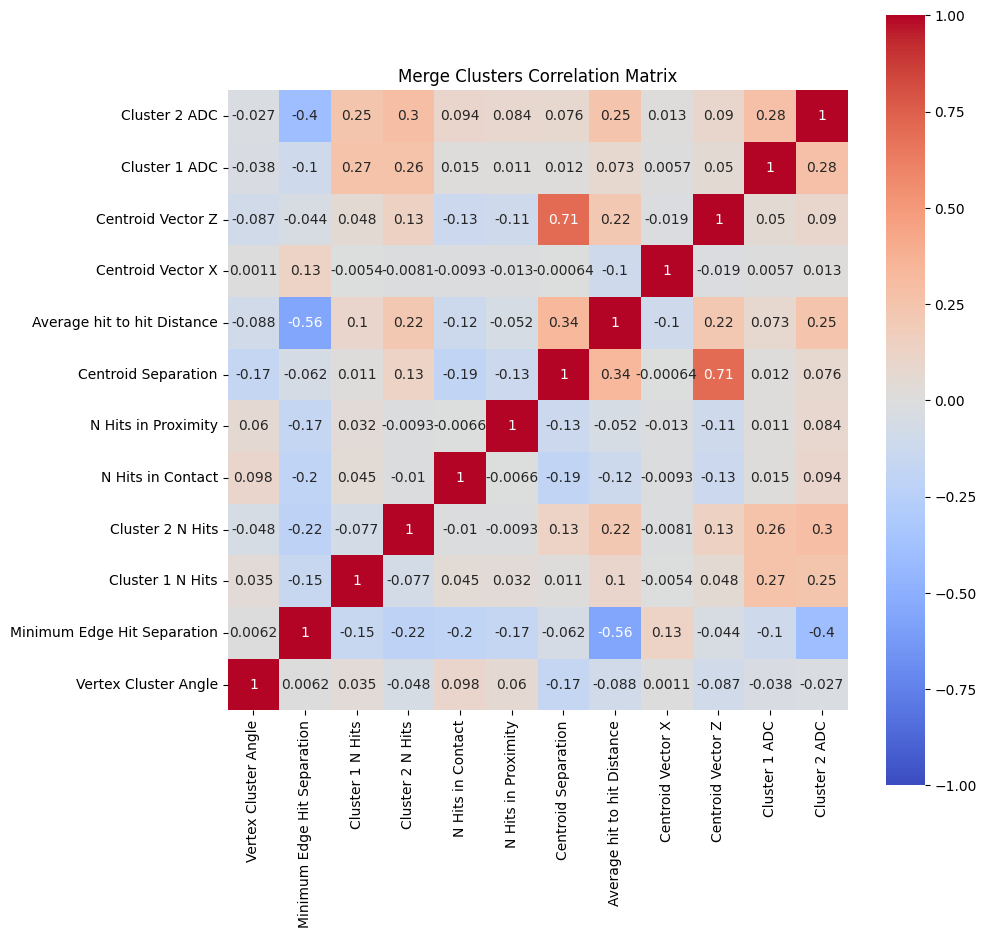

In [8]:
# Make correlation matricies
dfSig = df[df['Labels']==params['signalDefs'][0]].drop('Labels', axis=1)
dfBck = df[df['Labels']==params['signalDefs'][1]].drop('Labels', axis=1)

CorrelationDF(dfSig, params['labelNames'][0] + ' Correlation Matrix')
CorrelationDF(dfBck, params['labelNames'][1] + ' Correlation Matrix')

In [14]:
dfSig

,Vertex Cluster Angle,Minimum Edge Hit Separation,Maximum Edge Hit Separation,Cluster Centroid Separation,Average hit to hit Distance,Average hit to hit Angle
4,12.895300,12.07930,15.0507,12.78330,168.4190,13.1770
5,4.144930,9.79574,10.3566,9.88017,99.2883,10.0720
6,-3.557580,9.47829,14.0801,11.40380,134.2040,11.7792
7,0.839746,10000.00000,0.0000,4.62311,0.0000,0.0000
8,-10.655100,46.48770,46.7825,46.62030,0.0000,0.0000
...,...,...,...,...,...,...
1099084,-8.738790,10000.00000,0.0000,23.15360,0.0000,0.0000
1099086,-383.581000,10000.00000,0.0000,44.99160,0.0000,0.0000
1099087,-12.577100,26.88400,26.8894,27.65670,743.2850,26.8867
1099089,-12.048100,20.19250,20.2921,20.19150,408.6570,20.2423


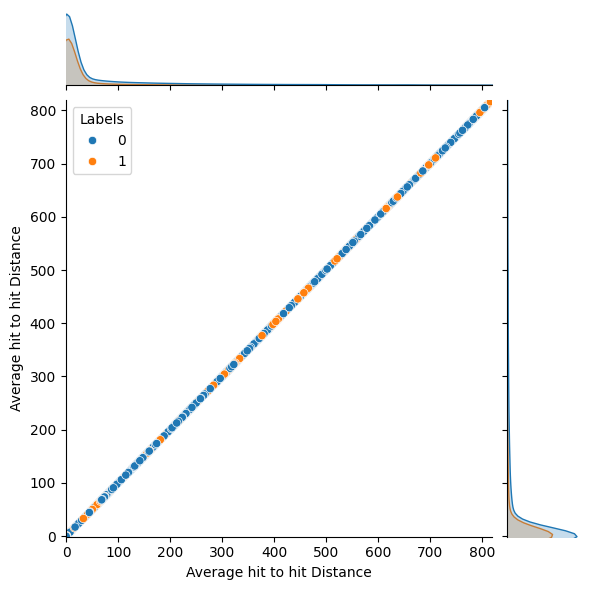

In [16]:
# If we want to make a plot comparing two variables;
xMetric = 'Average hit to hit Distance'
yMetric = 'Average hit to hit Distance'

sns.jointplot(data=df, x=xMetric, y=yMetric, hue='Labels',
              xlim=(np.quantile(df[xMetric], 0.02), np.quantile(df[xMetric], 0.98)), 
              ylim=(np.quantile(df[yMetric], 0.02), np.quantile(df[yMetric], 0.98)))

KeyboardInterrupt: 

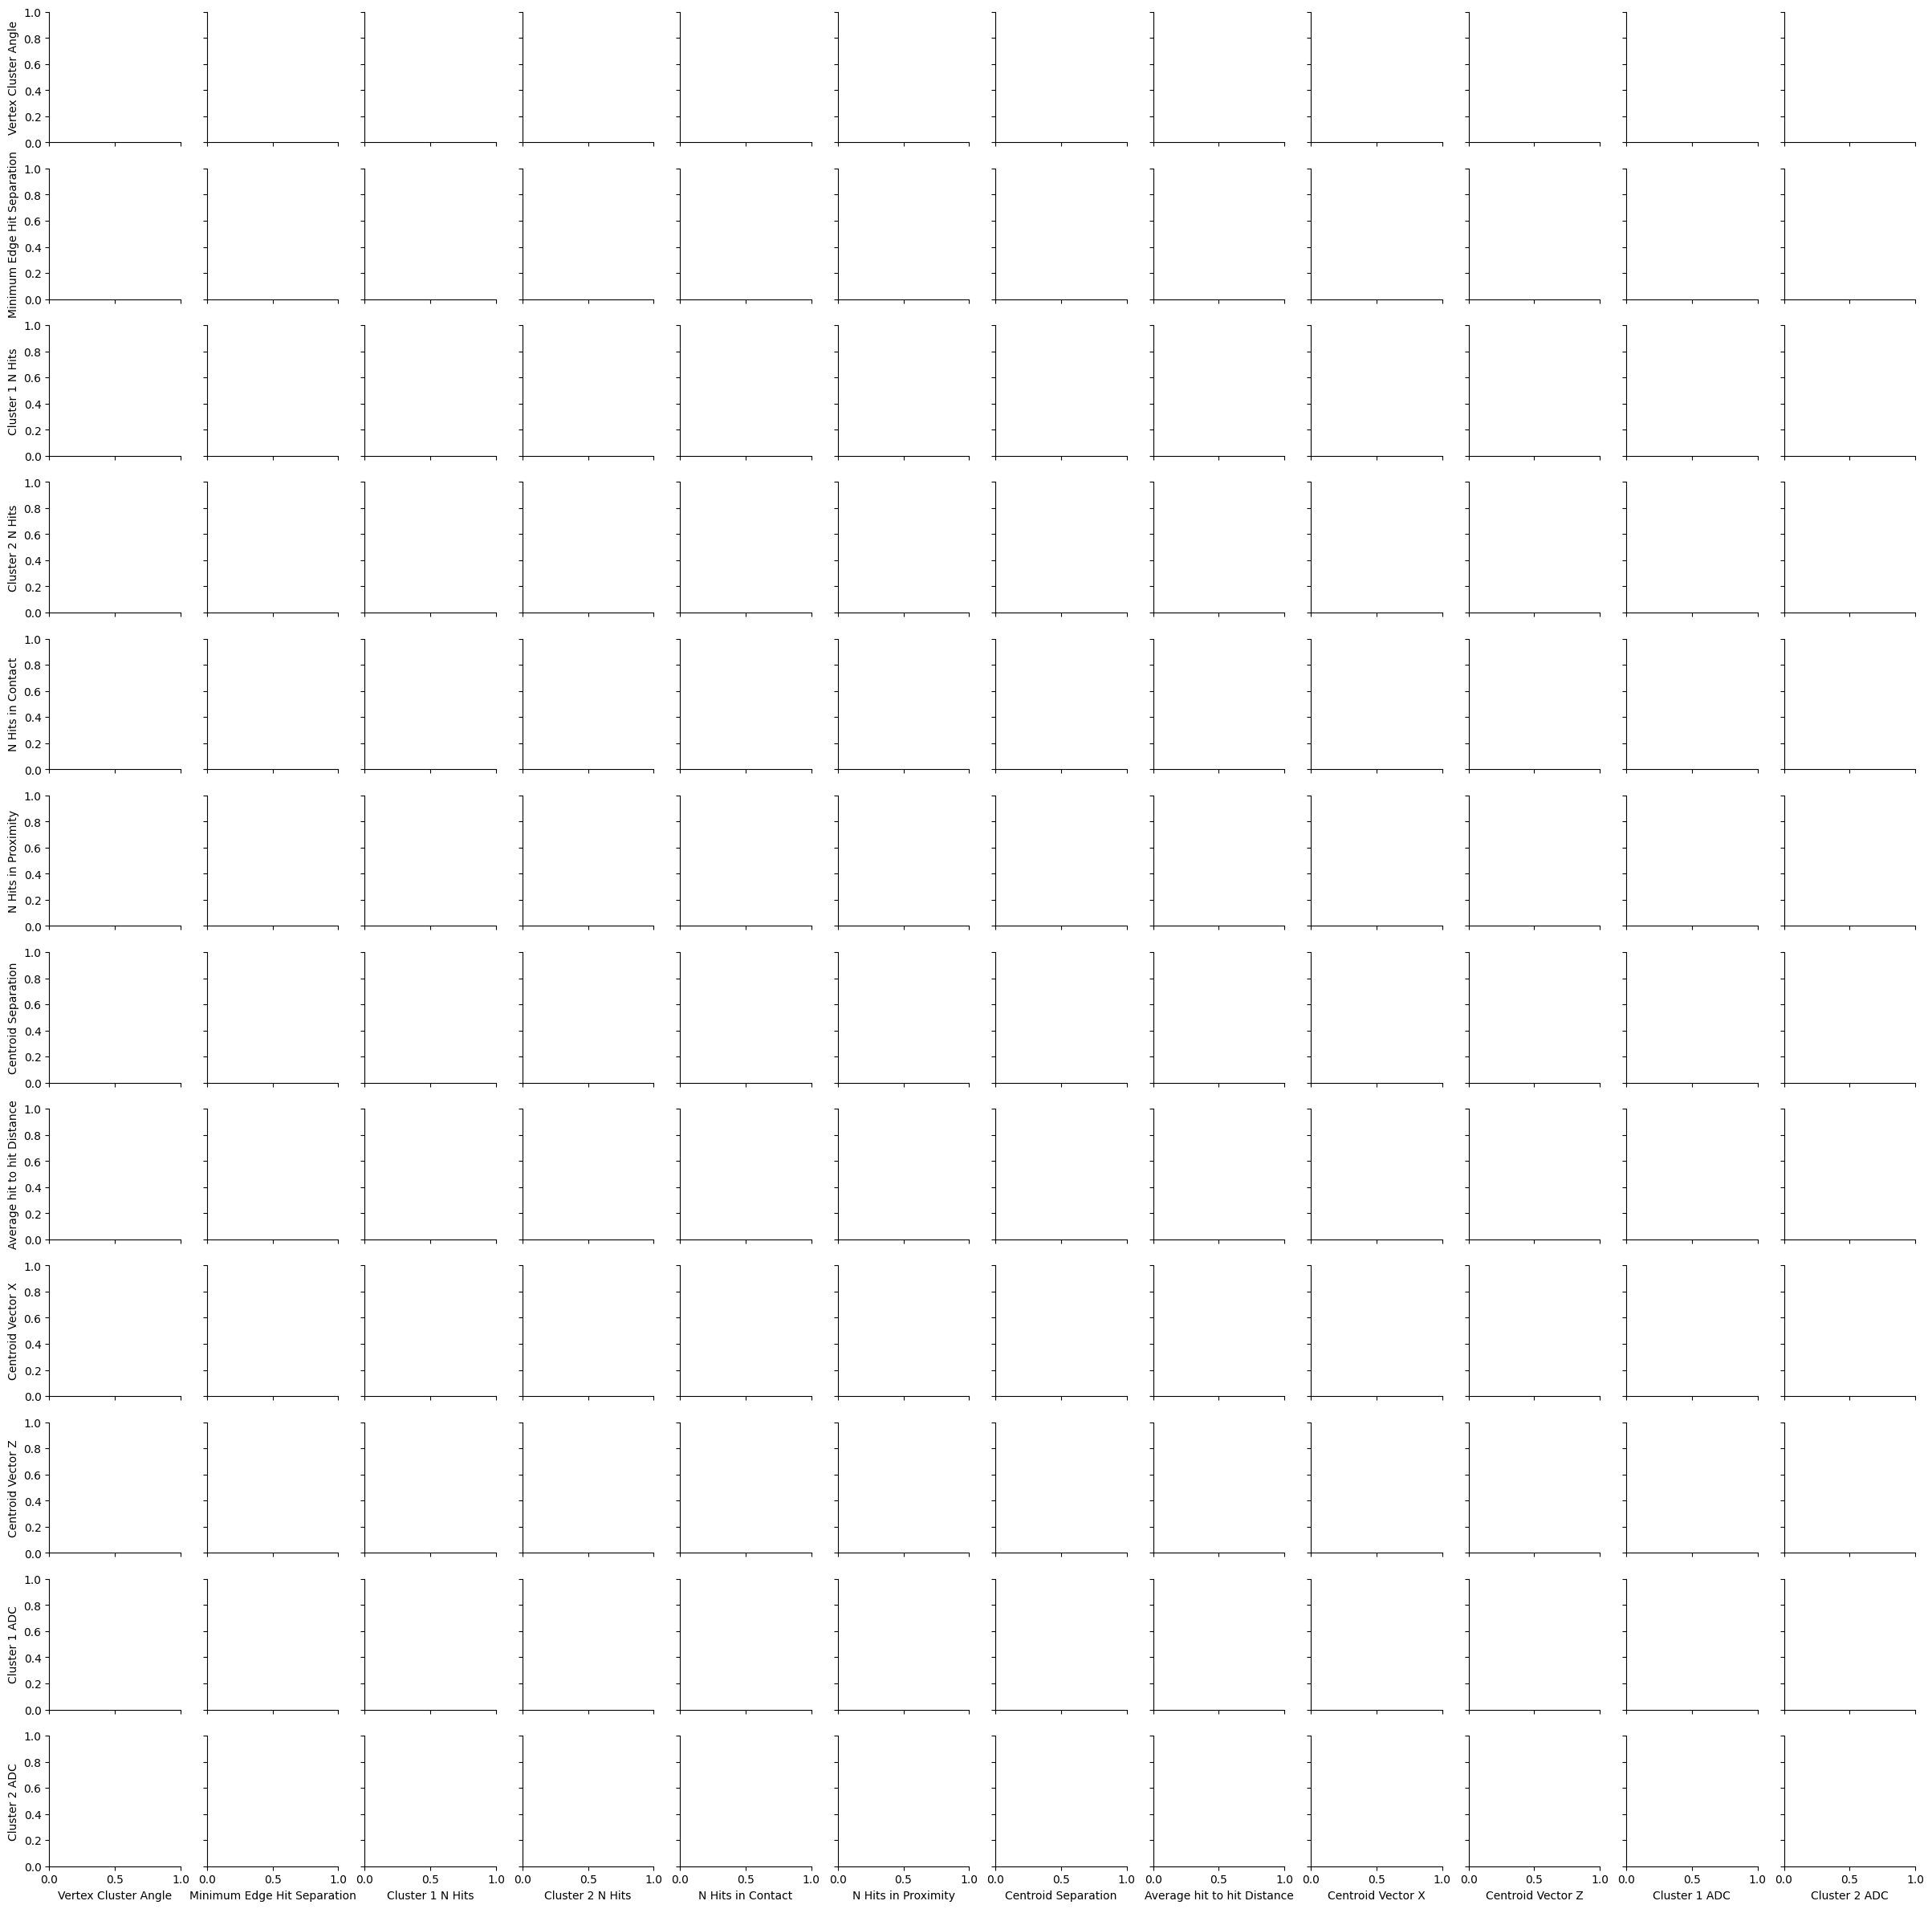

In [13]:
# For plotting all combos, not very useful when we have too many variables
sns.pairplot(df, hue='Labels')

In [23]:
# Define size of grid search
depthRange = 3
treeRange = 3

# Set up ranges for grid search
depthArray = np.linspace(1, depthRange, depthRange, dtype=int)
treeArray = np.logspace(0, treeRange-1, treeRange, dtype=int)
#treeArray = np.linspace(100, 100*treeRange, treeRange, dtype=int)

# Print arrays for debugging
print ("Depth Array:", depthArray)
print ("Tree Array: ", treeArray)

# Construct a dictionary to loop over
paramGrid = dict(estimator__max_depth=depthArray, n_estimators=treeArray)

# Perform the grid search
grid = GridSearchCV(baseBDT, param_grid=paramGrid, cv=cv, n_jobs=nCores, 
                    verbose=9, refit=True, return_train_score=True)


Depth Array: [1 2 3]
Tree Array:  [  1  10 100]


In [24]:
# Run the grid search
grid.fit(xTrain, yTrain)

print("The best parameters are %s with a score of %0.2f"% 
      (grid.best_params_, grid.best_score_))

# Put the output of the grid in a conveneant df
gridResults = pd.DataFrame(grid.cv_results_)
gridResults.rename(columns={"param_base_estimator__max_depth": "MaxDepth"}, inplace=True)
gridResults.rename(columns={"param_n_estimators": "NTrees"}, inplace=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/physics/phuvhw/.local/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The best parameters are {'estimator__max_depth': 3, 'n_estimators': 100} with a score of 0.72
[CV 5/5] END estimator__max_depth=2, n_estimators=1;, score=(train=0.690, test=0.692) total time=   0.2s
[CV 1/5] END estimator__max_depth=3, n_estimators=1;, score=(train=0.701, test=0.705) total time=   0.2s
[CV 2/5] END estimator__max_depth=3, n_estimators=1;, score=(train=0.699, test=0.698) total time=   0.2s
[CV 3/5] END estimator__max_depth=3, n_estimators=1;, score=(train=0.702, test=0.701) total time=   0.2s
[CV 5/5] END estimator__max_depth=3, n_estimators=1;, score=(train=0.699, test=0.698) total time=   0.2s
[CV 4/5] END estimator__max_depth=3, n_estimators=1;, score=(train=0.703, test=0.704) total time=   0.2s
[CV 2/5] END estimator__max_depth=1, n_estimators=10;, score=(train=0.709, test=0.707) total time=   0.6s
[CV 4/5] END estimator__max_depth=1, n_estimators=10;, score=(train=0.710, test=0.714) total time=   0.7s
[CV 1/5] END estimator__max_depth=1, n_estimators=10;, score=(tr

In [25]:
gridResults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,NTrees,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.090792,0.000766,0.004643,0.000350,1,1,"{'estimator__max_depth': 1, 'n_estimators': 1}",0.633017,0.628026,0.628775,...,0.630921,0.004815,9,0.625768,0.627765,0.627546,0.624832,0.628389,0.626860,0.001336
1,0.696345,0.035979,0.009998,0.001905,1,10,"{'estimator__max_depth': 1, 'n_estimators': 10}",0.713252,0.707387,0.707138,...,0.711180,0.003226,6,0.706380,0.708813,0.711496,0.710342,0.709468,0.709300,0.001715
2,4.258768,0.108030,0.048089,0.000504,1,100,"{'estimator__max_depth': 1, 'n_estimators': 100}",0.721612,0.716247,0.713626,...,0.718143,0.002851,3,0.716269,0.718390,0.718109,0.717454,0.715863,0.717217,0.000996
3,0.154914,0.001892,0.005056,0.000566,2,1,"{'estimator__max_depth': 2, 'n_estimators': 1}",0.698652,0.689918,0.689918,...,0.692862,0.003268,8,0.688379,0.690750,0.690282,0.689690,0.690282,0.689877,0.000821
4,1.159350,0.116246,0.011240,0.002399,2,10,"{'estimator__max_depth': 2, 'n_estimators': 10}",0.719616,0.710007,0.707512,...,0.713152,0.005145,5,0.710934,0.709998,0.711090,0.714896,0.711059,0.711596,0.001699
5,6.956367,0.124014,0.047907,0.001272,2,100,"{'estimator__max_depth': 2, 'n_estimators': 100}",0.725605,0.721363,0.715373,...,0.722685,0.004004,2,0.720262,0.725940,0.725441,0.728280,0.722383,0.724461,0.002817
6,0.203884,0.003817,0.003693,0.000360,3,1,"{'estimator__max_depth': 3, 'n_estimators': 1}",0.705141,0.697654,0.700898,...,0.701098,0.002946,7,0.700764,0.699111,0.702324,0.703073,0.698986,0.700852,0.001650
7,1.310230,0.058312,0.008712,0.000267,3,10,"{'estimator__max_depth': 3, 'n_estimators': 10}",0.716746,0.713501,0.710756,...,0.715024,0.002589,4,0.711901,0.716019,0.717080,0.713804,0.720200,0.715801,0.002836
8,9.323201,0.084390,0.046260,0.000605,3,100,"{'estimator__max_depth': 3, 'n_estimators': 100}",0.731220,0.724108,0.719990,...,0.724307,0.003986,1,0.727125,0.732023,0.728186,0.722165,0.727375,0.727375,0.003145


In [29]:
testScores = gridResults.pivot(columns = "MaxDepth", index = "NTrees", values = "mean_test_score")
testStd = gridResults.pivot(columns = "MaxDepth", index =  "NTrees", values = "std_test_score")
trainScores = gridResults.pivot(columns = "MaxDepth", index = "NTrees", values = "mean_train_score")

trainTestDiff = trainScores - testScores

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(testScores, cmap='bwr', linewidths=0, annot=True, fmt = ".4f")
plt.title('Validation accuracy: Test')
plt.gca().invert_yaxis()
plt.savefig('TestScores.pdf')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(testStd, cmap='bwr', linewidths=0, annot=True, fmt = ".4f")
plt.title('Validation accuracy: Std Test Score')
plt.gca().invert_yaxis()
plt.savefig('TrainStds.pdf')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(trainScores, cmap='bwr', linewidths=0, annot=True, fmt = ".4f")
plt.title('Validation accuracy: Train')
plt.gca().invert_yaxis()
plt.savefig('TrainScores.pdf')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(trainTestDiff, cmap='bwr', linewidths=0, annot=True, fmt = ".4f")
plt.title('Validation accuracy: Train Test Diff')
plt.gca().invert_yaxis()
plt.savefig('TrainTestDiff.pdf')
plt.show()

KeyError: 'MaxDepth'

In [30]:
params['MaxDepth'] = 3
params['nTrees'] = 100

# Create the base BDT to vary the params from and compare to
baseBDT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=params['TreeDepth']),algorithm='SAMME', 
                         random_state=42, n_estimators=params['nTrees'])

In [31]:
# Reference BDT with controlled hyperparams
baseBDT.fit(xTrain,yTrain)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=100, random_state=42)

In [32]:
import sklearn as sk
sk.__version__

grid

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(max_depth=3),
                                          n_estimators=100, random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': array([1, 2, 3]),
                         'n_estimators': array([  1,  10, 100])},
             return_train_score=True, verbose=9)

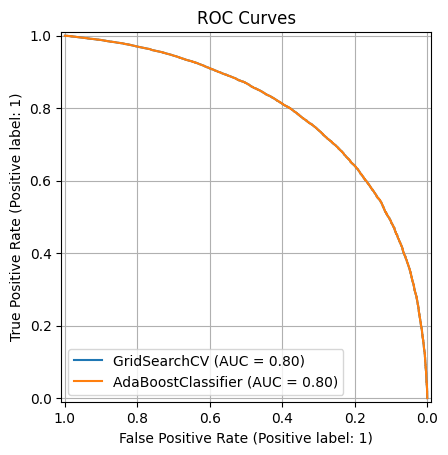

In [33]:
# Plot ROC curves
fig, ax = plt.subplots()
metrics.RocCurveDisplay.from_estimator(estimator = grid, X = xTest, y = yTest, ax=ax)
metrics.RocCurveDisplay.from_estimator(estimator = baseBDT, X = xTest, y = yTest, ax=ax)

plt.title("ROC Curves")
ax.invert_xaxis()
ax.legend()
ax.grid()

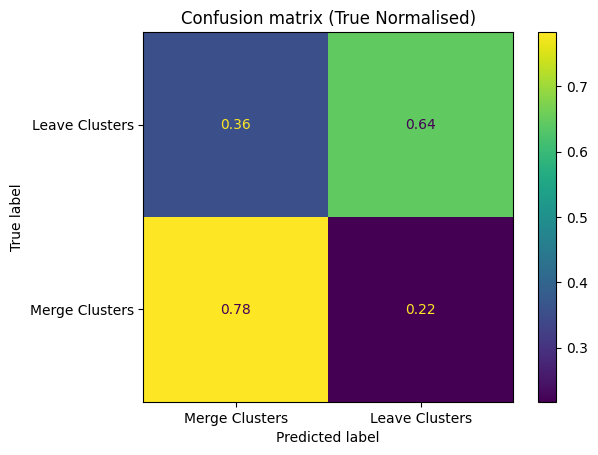

In [34]:
# Plot Confusion Matricies
fig, ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(grid, xTest, yTest, display_labels=params['labelNames'],
                             ax=ax, normalize='true')

ax.invert_xaxis()
#ax.invert_zaxis()
plt.title("Confusion matrix (True Normalised)")
plt.show()

In [13]:
# Print more detailed performance info
bdtPredicted = baseBDT.predict(xTest)
gridPredicted = grid.predict(xTest)

print ("Background (0): ", params['labelNames'][0])
print ("Signal (1): ", params['labelNames'][1])
print ("BDT:\n", metrics.classification_report(yTest, bdtPredicted))
print ("Grid:\n", metrics.classification_report(yTest, gridPredicted))

Background (0):  Leave Clusters
Signal (1):  Merge Clusters
BDT:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89     60708
           1       0.68      0.45      0.54     19090

    accuracy                           0.82     79798
   macro avg       0.76      0.69      0.72     79798
weighted avg       0.80      0.82      0.80     79798

Grid:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     60708
           1       0.70      0.44      0.54     19090

    accuracy                           0.82     79798
   macro avg       0.77      0.69      0.71     79798
weighted avg       0.81      0.82      0.80     79798



In [58]:
# Search performance over training sample size
train_sizes_array = np.linspace(0.0,1, 20)

train_sizes, train_scores, test_scores = learning_curve(baseBDT, features,
    labels, train_sizes=train_sizes_array[1:], n_jobs=nCores, verbose=9, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 15688  31377  47066  62755  78444  94133 109822 125511 141200 156888
 172577 188266 203955 219644 235333 251022 266711 282400 298089]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  95 | elapsed:  1.2min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  19 out of  95 | elapsed:  4.8min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done  30 out of  95 | elapsed:  7.2min remaining: 15.5min
[Parallel(n_jobs=-1)]: Done  41 out of  95 | elapsed: 10.5min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  52 out of  95 | elapsed: 13.5min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  63 out of  95 | elapsed: 16.1min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed: 19.4min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  85 out of  95 | elapsed: 21.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed: 26.0min finished


[CV] END ..................., score=(train=0.806, test=0.806) total time=   4.9s
[CV] END ..................., score=(train=0.814, test=0.814) total time=  28.1s
[CV] END ..................., score=(train=0.813, test=0.812) total time=  55.7s
[CV] END ..................., score=(train=0.811, test=0.812) total time= 1.4min
[CV] END ..................., score=(train=0.812, test=0.812) total time= 1.9min
[CV] END ..................., score=(train=0.813, test=0.811) total time=  22.1s
[CV] END ..................., score=(train=0.812, test=0.811) total time=  35.2s
[CV] END ..................., score=(train=0.815, test=0.813) total time=  54.9s
[CV] END ..................., score=(train=0.815, test=0.814) total time= 1.4min
[CV] END ..................., score=(train=0.815, test=0.814) total time= 1.9min
[CV] END ..................., score=(train=0.813, test=0.809) total time=  28.5s
[CV] END ..................., score=(train=0.815, test=0.811) total time=  42.2s
[CV] END ...................

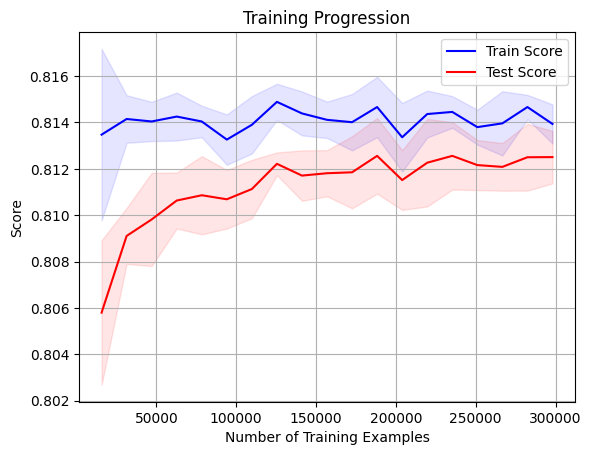

In [59]:
# Plot training progression
fig, ax = plt.subplots()
plt.title("Training Progression")
plt.xlabel("Number of Training Examples")
plt.ylabel("Score")

plt.plot(train_sizes, mean_train_scores, label='Train Score', color='b')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")

plt.plot(train_sizes, mean_test_scores, label='Test Score', color='r')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
#plt.plot(train_sizes, std_test_scores, label='Test Score Std.', color='k')

plt.grid()
plt.legend()

In [21]:
# Search over a metric
cppalplhaArray = np.linspace(0,0.001,11)

train_scores, test_scores = validation_curve(
    baseBDT, features, labels, param_name='base_estimator__ccp_alpha',
    param_range=cppalplhaArray, n_jobs=nCores, verbose=9, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

print ("Means: "+str(mean_test_scores)+" and std. "
       +str(std_test_scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/physics/phuvhw/python_envs/hierarchy_tools/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/home/physics/phuvhw/python_envs/hierarchy_tools/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/home/physics/phuvhw/python_envs/hierarchy_tools/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See 

Means: [0.76208699 0.76124266 0.76053662 0.75993704 0.75884341 0.75927741
 0.75665798 0.75804093 0.75783531 0.75759875 0.75380745] and std. [0.00043484 0.0004502  0.00063696 0.00101822 0.00121462 0.00077608
 0.00317449 0.00068667 0.00049877 0.00047619 0.00381296]


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 62.4min finished


[CV] END ..................., score=(train=0.764, test=0.762) total time=  36.7s
[CV] END ..................., score=(train=0.762, test=0.761) total time= 1.6min
[CV] END ..................., score=(train=0.762, test=0.762) total time= 2.6min
[CV] END ..................., score=(train=0.763, test=0.763) total time= 3.5min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 4.4min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 2.4min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 3.2min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 4.2min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 1.6min
[CV] END ..................., score=(train=0.763, test=0.762) total time= 2.5min
[CV] END ..................., score=(train=0.764, test=0.763) total time= 3.5min
[CV] END ..................., score=(train=0.762, test=0.761) total time= 4.4min
[CV] END ...................

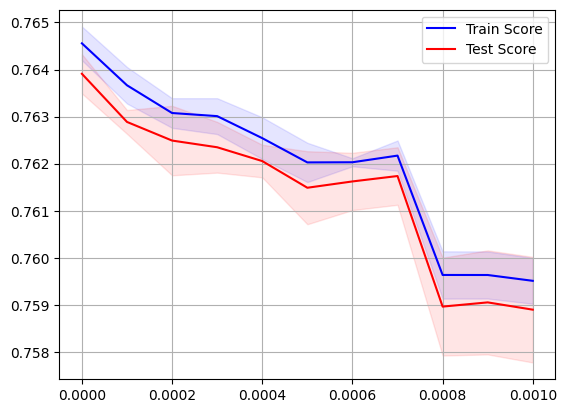

In [67]:
# Plot grid search
plt.plot(cppalplhaArray, mean_train_scores, label='Train Score', color='b')
plt.fill_between(cppalplhaArray, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")
plt.plot(cppalplhaArray, mean_test_scores, label='Test Score', color='r')
plt.fill_between(cppalplhaArray, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
plt.grid()
#plt.xscale('log')
plt.legend()

In [46]:
# Search over a metric
learningRateArray = np.linspace(0.1,1.5,15)

train_scores, test_scores = validation_curve(
    baseBDT, features, labels, param_name='learning_rate',
    param_range=learningRateArray, n_jobs=nCores, verbose=9, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

print ("Means: "+str(mean_test_scores)+" and std. "
       +str(std_test_scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [235]:
# Plot grid search
plt.plot(learningRateArray, mean_train_scores, label='Train Score', color='b')
plt.fill_between(learningRateArray, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")
plt.plot(learningRateArray, mean_test_scores, label='Test Score', color='r')
plt.fill_between(learningRateArray, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
plt.grid()
#plt.xscale('log')
plt.legend()

NameError: name 'learningRateArray' is not defined

                       Features  Importance Score
4             N Hits in Contact          0.000000
5           N Hits in Proximity          0.000000
7   Average hit to hit Distance          0.021138
1   Minimum Edge Hit Separation          0.047548
2              Cluster 1 N Hits          0.058684
3              Cluster 2 N Hits          0.059493
8             Centroid Vector X          0.080502
6           Centroid Separation          0.101291
10                Cluster 1 ADC          0.118573
9             Centroid Vector Z          0.137023
0          Vertex Cluster Angle          0.147448
11                Cluster 2 ADC          0.228300


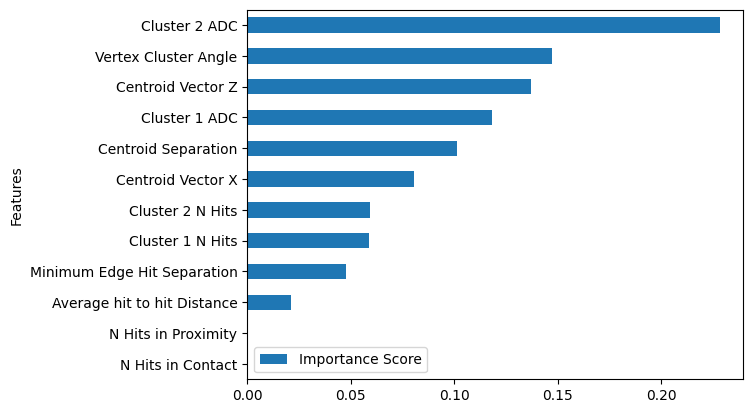

In [35]:
# Plot importance of features
importanceDF = pd.DataFrame({'Features': featureNames, 'Importance Score':baseBDT.feature_importances_})
print (importanceDF.sort_values(by=['Importance Score']))

ax = importanceDF.sort_values(by=['Importance Score'])\
    .plot(kind='barh', x='Features', y='Importance Score')

In [36]:
# Print all tunable params
baseBDT.get_params().keys()

dict_keys(['algorithm', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__monotonic_cst', 'estimator__random_state', 'estimator__splitter', 'estimator', 'learning_rate', 'n_estimators', 'random_state'])

(40069, 12)
(40069,)
(40069, 12)
(40069,)
KS Signal:     0.003955744081394541 with P value: 0.992485406068908
KS BackGround: 0.019106481111655915 with P value: 0.00472422492558858


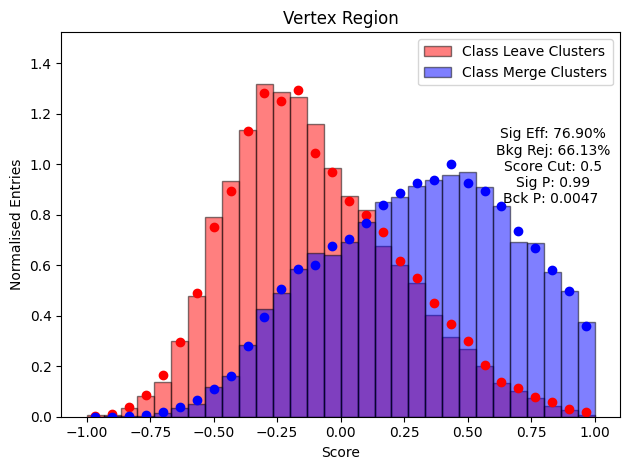

In [37]:
import PandoraBDT
from importlib import reload

reload (PandoraBDT)
from PandoraBDT import *

params["nBins"] = 30
params["OptimalBinCut"] = 15

print (np.shape(xTest))
print (np.shape(yTest))
print (np.shape(xTrain))
print (np.shape(yTrain))


PlotBdtKSScores(baseBDT, xTest, yTest, xTrain, yTrain, 'Vertex Region', params)

In [38]:
WriteXmlFile("LowEBackgroundClusterMergingFixed.xml", baseBDT, BDTName)
SerializeToPkl(BDTName+".pkl", baseBDT)